<a href="https://colab.research.google.com/github/adamzbikowski/Process-Mining-Dissertation/blob/main/pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline 1: predicting missing values for activity

##Section 0: Customisation

**Note on usage:**
To customise the pipeline, only alter the parameters in this section.

In [70]:
# The following parameters can be customised:

# change depending on which branch the queries have been pushed to
BRANCH = "sql-queries" 

# change this to change which query is being used
QUERY_NAME = "event_log_mvp.sql"

# change to alter the number of random traces being selected
NUM_TRACES = 100

# change to alter the prefix/suffix length
PREFIX_LENGTH = 5

# change to alter the size of the test and validation sets
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2





## Section 1: Loading event log

In [3]:
# installing prerequisites
# certain packages are not installed by default on google colab
!pip install pm4py


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stringdist: filename=StringDist-1.0.9-cp38-cp38-linux_x86_64.whl size=24938 sha256=396b3c246a294974a090e5bfd8e647c35807a8afd3e7e9e1f5ef574f77d5c3fa
  Stored in directory: /root/.cache/pip/wheels/7a/64/e2/16f6a25a62a78f951c1715adb24ba2271ae9d7872f42378c3a
Successfully built stringdist


In [4]:
from google.colab import auth
auth.authenticate_user()

In [57]:
# this assumes that the user has access to the mimic-iii dataset 
# replace project name to the project containing mimic-iii
project_name = "processmining-367815" 
from google.cloud import bigquery
client = bigquery.Client(project=project_name)

In [58]:
import requests

# read a query from the github repository
url = f"https://raw.githubusercontent.com/adamzbikowski/Process-Mining-Dissertation/{BRANCH}/sql_queries/{QUERY_NAME}"
query_bytes = requests.get(url).content

# we must now decode this to turn the query into a string 
query = query_bytes.decode("utf-8")

In [59]:
import pandas as pd

# loading event log from mimic-iii using bigQuery
event_log = client.query(query).to_dataframe()
# convert timestamp from object to datetime64
event_log["timestamp"] = pd.to_datetime(event_log["timestamp"])
event_log


,patient,activity,timestamp
0,109129,Admitted,2188-07-11 00:58:00
1,121510,Admitted,2133-04-16 21:12:00
2,106469,Admitted,2109-02-16 23:14:00
3,133732,Admitted,2167-10-06 18:35:00
4,119601,Admitted,2198-02-09 14:58:00
...,...,...,...
140355,121061,Transfer,2126-07-06 22:00:47
140356,150357,Transfer,2168-09-25 13:23:15
140357,166021,Transfer,2146-09-15 03:16:45
140358,137177,Transfer,2193-01-07 16:03:50


## Section 2: Process Discovery

In [60]:
import pm4py as pm

event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')
# lets get some information about the event log
n_events = len(event_log)
n_cases = len(event_log.patient.unique())
start_events = pm.get_start_activities(event_log)
end_events = pm.get_end_activities(event_log)
print(f"Number of cases: {n_cases}\nNumber of events: {n_events}")
print(f"Start events: {start_events}\nEnd events: {end_events}")


<ipython-input-60-aedec179434f>:3: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')


Number of cases: 42652
Number of events: 140360
Start events: {'Admitted': 36881, 'Transfer': 5716, 'Discharged': 55}
End events: {'Discharged': 42563, 'Transfer': 85, 'Admitted': 4}


In [61]:
# lets improve the event log by filtering out the cases that do not start or end with a patient being admitted or discharged
# this will simplify the model

event_log = pm.filter_start_activities(event_log, ['Admitted'])
event_log = pm.filter_end_activities(event_log,['Discharged'])

In [10]:
net, initial_marking, final_marking = pm.discover_petri_net_alpha(event_log)

/usr/local/lib/python3.8/dist-packages/pm4py/algo/discovery/dfg/adapters/pandas/df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


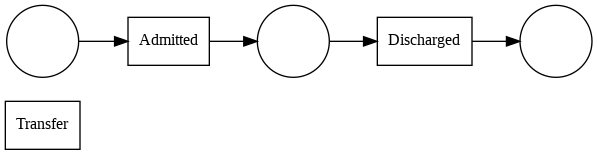

In [11]:
import graphviz
pm.view_petri_net(petri_net=net)

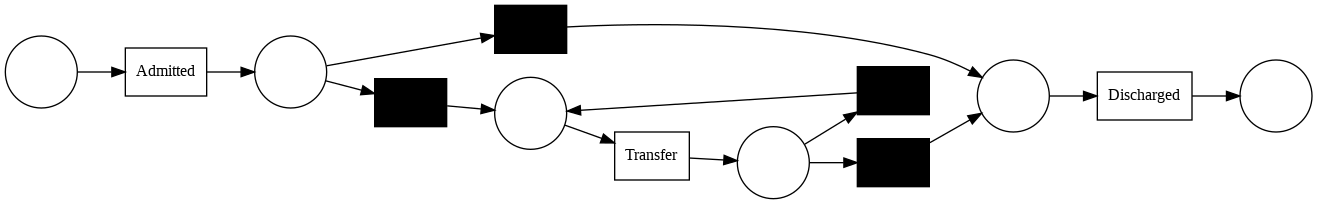

In [12]:
# inductive miner
# much better result than when using alpha miner, petri net 
net, initial_marking, final_marking = pm.discover_petri_net_inductive(event_log)
pm.view_petri_net(petri_net=net)

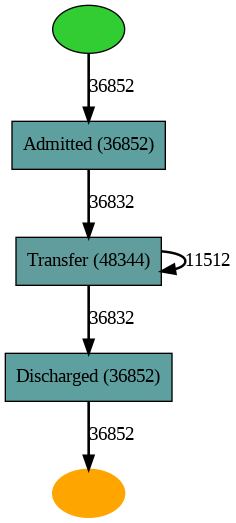

In [13]:
# heuristic miner
heu_net = pm.discover_heuristics_net(event_log, dependency_threshold=0.99)
pm.view_heuristics_net(heu_net)

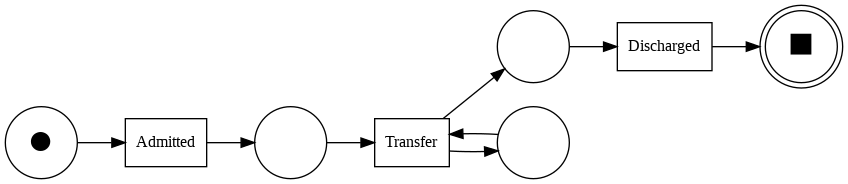

In [14]:
# petri net from heuristics miner
net, im, fm = pm.discover_petri_net_heuristics(event_log, dependency_threshold=0.99)
pm.view_petri_net(net, im, fm)

## Section 3: Data Pre Processing



In [62]:
from pandas.core.window.ewm import partial
import random
# select the first 100 cases to test the LSTM methodology
# lets first add a trace column to the event_log
event_log['trace'] = event_log.groupby(['patient']).ngroup()

# we can now select 100 random traces,
# this will be repeated with a a larger number of traces
# lets first initialise a random seed
random.seed(9)
random_traces = []

for i in range(0,NUM_TRACES):
  random_traces.append(random.randrange(0,n_cases))

df = event_log[event_log['trace'].isin(random_traces)]
partial_el = df[['trace', 'activity', 'timestamp' ]].reset_index(drop=True)
partial_el

,trace,activity,timestamp
0,253,Admitted,2187-07-25 11:58:00
1,253,Transfer,2187-07-25 11:59:27
2,253,Transfer,2187-07-26 11:56:57
3,253,Discharged,2187-07-30 13:10:00
4,345,Admitted,2108-01-10 22:33:00
...,...,...,...
291,36376,Admitted,2173-05-31 14:23:00
292,36376,Transfer,2173-05-31 14:27:08
293,36376,Transfer,2173-05-31 20:36:45
294,36376,Transfer,2173-06-01 13:11:12


In [76]:
# lets represent each activity using a statically defined number
# this will prevent the need for using an embedding layer when traing the LSTM
unique_activities = partial_el['activity'].unique()
n_activities = len(unique_activities) + 1
encode_activity = {unique_activities[i-1] : f'{i}' for i in range(1,n_activities)}

# lets also create a second dictionary that will be used to decode predicted activities
decode_activity = {f'{i}' : unique_activities[i-1] for i in range(1, len(unique_activities)+ 1)}
encode_activity, decode_activity


({'Admitted': '1', 'Transfer': '2', 'Discharged': '3'},
 {'1': 'Admitted', '2': 'Transfer', '3': 'Discharged'})

In [64]:
import numpy as np
# create a new labeled data frame

def label(el):
  # initialise data frame 
 
  prefix_arr, suffix_arr, label_arr = [], [], []
  labeled_arr = []
  unique_traces = el['trace'].unique()
  traces = {x : pd.DataFrame() for x in unique_traces} 

  for t in unique_traces:
    traces[t] = el[:][el.trace == t]  
  
  for t in unique_traces:
    df = traces[t].sort_values(by='timestamp')
    activities = []
    for i in df.index:
      activity = encode_activity.get(df['activity'][i])
      activities.append(activity)
    
    length = len(activities)
    
    for i in range(length):

      # prefix = activities[:i]
      label = activities[i]
      prefix = activities[:i]
      suffix = []

      if i != length - 1:
        suffix = activities[i+1:]
      padding = []

      while len(prefix) + len(padding) < PREFIX_LENGTH:
        padding.append('0')
      
      prefix = padding + prefix
        
      while len(suffix) < PREFIX_LENGTH:
        suffix.append('0')

      prefix_arr.append(np.array(prefix[0:PREFIX_LENGTH], dtype=int))
      suffix_arr.append(np.array(suffix[0:PREFIX_LENGTH], dtype=int))
      label_arr.append(label)

  return pd.DataFrame({'prefix' : prefix_arr, 
                       'suffix' : suffix_arr,
                       'label' : label_arr})
 

In [71]:
from sklearn.model_selection import train_test_split

# label event log
labeled_el = label(partial_el)

# split event log into a train and test set  
train_el, test_el  = train_test_split(labeled_el, test_size=TEST_SIZE, random_state=9)
train_el


,prefix,suffix,label
69,"[0, 0, 0, 0, 1]","[3, 0, 0, 0, 0]",2
54,"[0, 0, 0, 1, 2]","[0, 0, 0, 0, 0]",3
99,"[0, 0, 1, 2, 2]","[0, 0, 0, 0, 0]",3
103,"[0, 0, 0, 0, 0]","[2, 2, 3, 0, 0]",1
240,"[0, 0, 0, 0, 0]","[2, 2, 3, 0, 0]",1
...,...,...,...
65,"[0, 0, 0, 0, 0]","[2, 3, 0, 0, 0]",1
125,"[0, 0, 0, 0, 1]","[3, 0, 0, 0, 0]",2
251,"[0, 0, 0, 0, 0]","[2, 3, 0, 0, 0]",1
56,"[0, 0, 0, 0, 1]","[2, 3, 0, 0, 0]",2


In [72]:
from copy import deepcopy

# declare the label of each activity in the test set as missing
# return actual labels as targets array for validation
def missing(el):
 
  # need to deepcopy targets to derefrence them from dataframe  
  targets = deepcopy(el['label'])
  el['label'] = 'missing'
  return el, targets.to_numpy()

In [73]:
# train_targets = train_el['label'].to_numpy()
test_el, test_targets = missing(test_el)
test_el, test_targets

(              prefix           suffix    label
 95   [0, 0, 0, 1, 2]  [0, 0, 0, 0, 0]  missing
 127  [0, 0, 0, 0, 0]  [2, 3, 0, 0, 0]  missing
 31   [0, 0, 0, 1, 2]  [2, 2, 2, 3, 0]  missing
 83   [0, 0, 1, 2, 2]  [2, 3, 0, 0, 0]  missing
 291  [0, 0, 0, 0, 0]  [2, 2, 2, 3, 0]  missing
 133  [0, 0, 1, 2, 2]  [0, 0, 0, 0, 0]  missing
 89   [0, 0, 0, 0, 0]  [2, 2, 3, 0, 0]  missing
 123  [0, 0, 1, 2, 2]  [0, 0, 0, 0, 0]  missing
 124  [0, 0, 0, 0, 0]  [2, 3, 0, 0, 0]  missing
 162  [0, 0, 0, 1, 2]  [0, 0, 0, 0, 0]  missing
 88   [0, 0, 0, 1, 2]  [0, 0, 0, 0, 0]  missing
 105  [0, 0, 0, 1, 2]  [3, 0, 0, 0, 0]  missing
 281  [0, 0, 0, 1, 2]  [0, 0, 0, 0, 0]  missing
 37   [0, 0, 0, 0, 1]  [2, 3, 0, 0, 0]  missing
 177  [0, 0, 0, 0, 1]  [2, 3, 0, 0, 0]  missing
 15   [0, 0, 0, 1, 2]  [3, 0, 0, 0, 0]  missing
 201  [0, 0, 0, 0, 1]  [2, 3, 0, 0, 0]  missing
 152  [0, 0, 0, 0, 1]  [2, 2, 3, 0, 0]  missing
 172  [0, 0, 0, 1, 2]  [0, 0, 0, 0, 0]  missing
 57   [0, 0, 0, 1, 2]  [3, 0, 0, 0, 0]  

In [74]:
# create validation set
train_el, validation_el = train_test_split(train_el, test_size=VALIDATION_SIZE, random_state=9)

In [77]:
from keras.utils import to_categorical

def format_input(el, train=False):

  prefix_x = np.array(el['prefix'])
  prefix_x = np.stack(prefix_x)
  prefix_x = prefix_x.reshape(prefix_x.shape[0], prefix_x.shape[1], 1)
  
  suffix_x = np.array(el['suffix'])
  suffix_x = np.stack(suffix_x)
  suffix_x = suffix_x.reshape(suffix_x.shape[0], suffix_x.shape[1], 1)

  x = np.concatenate(([prefix_x], [suffix_x]))

  y = np.array(el['label'])
  y = np.stack(y)
  
  if train is False:
    y_encoded = to_categorical(y,n_activities)
    return x, y_encoded
  
  return x, y

In [79]:
train_x, train_y = format_input(train_el) 
validation_x, validation_y = format_input(validation_el)
test_x, test_y = format_input(test_el, train=True)


## Section 4: Predicting Missing Activities using LSTM

In [81]:
# forwards LSTM
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM, Dense, Softmax, Bidirectional, Embedding


model = Sequential()
model.add(Embedding(input_dim=n_activities, output_dim=50))
model.add(LSTM(50, activation='relu', return_sequences=False, input_shape=(PREFIX_LENGTH, 1)))
model.add(Dense(n_activities, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
model.fit(train_x[0], train_y, validation_data=(validation_x[0], validation_y), epochs=10)
# model.fit(train_x[0], train, epochs=10)



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 50)          200       
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_8 (Dense)             (None, 4)                 204       
                                                                 
Total params: 20,604
Trainable params: 20,604
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
6/6 [==============================] - 2s 83ms/step - loss: 1.3825 - accuracy: 0.3032 - val_loss: 1.3716 - val_accuracy: 0.2083
Epoch 2/10
6/6 [==============================] - 0s 15ms/step - loss: 1.3630 - accuracy: 0.4255 - val_loss: 1.3551 - val_accuracy: 0.5000
Epoch 3/10
6/6 [====================

In [82]:
predictions_prefix = model.predict(test_x[0])
# predictions

2/2 [==============================] - 0s 10ms/step


In [83]:
def evaluate(predictions, verbose=False):
  correct = 0 
  incorrect = 0
  for i in range(len(test_targets)):
    prediction = np.argmax(predictions[i])
    if int(prediction) == int(test_targets[i]):
      correct += 1
    else:
      if verbose:
        print(f"predicted : {prediction}; expected : {test_targets[i]}")
      incorrect += 1


  accuracy = correct/(correct + incorrect)
  return accuracy

In [84]:
evaluate(predictions_prefix)

0.5

In [53]:
# backwards LSTM
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM, Dense, Softmax, Bidirectional, Embedding


model = Sequential()
model.add(Embedding(input_dim=4, output_dim=50))
model.add(LSTM(50, activation='relu', return_sequences=False, input_shape=(5, 1)))
# model.add(Softmax())
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
model.fit(train_x[1], train_y, validation_data=(validation_x[1], validation_y), epochs=10)
# model.fit(train_x[0], train, epochs=10)



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 50)          200       
                                                                 
 lstm_6 (LSTM)               (None, 50)                20200     
                                                                 
 dense_6 (Dense)             (None, 4)                 204       
                                                                 
Total params: 20,604
Trainable params: 20,604
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
56/56 [==============================] - 2s 12ms/step - loss: 1.2812 - accuracy: 0.3778 - val_loss: 1.0394 - val_accuracy: 0.4308
Epoch 2/10
56/56 [==============================] - 0s 7ms/step - loss: 0.4907 - accuracy: 0.7879 - val_loss: 0.2374 - val_accuracy: 0.9062
Epoch 3/10
56/56 [===============

In [51]:
predictions_suffix = model.predict(test_x[1])

18/18 [==============================] - 0s 3ms/step


In [52]:
evaluate(predictions_suffix)

0.9285714285714286

In [46]:
# averaging outputs
predictions = []
for p in zip(predictions_prefix, predictions_suffix):
 
  arr = []
  for i in range(0,4):
    arr.append((p[0][i]+p[1][i])/2)
  predictions += [arr]

predictions = np.array(predictions)

evaluate(predictions, verbose=True)


predicted : 3; expected : 2
predicted : 3; expected : 2
predicted : 3; expected : 2
predicted : 3; expected : 2
predicted : 3; expected : 2
predicted : 3; expected : 2
predicted : 3; expected : 2
predicted : 3; expected : 2
predicted : 3; expected : 2
predicted : 3; expected : 2


0.9821428571428571

In [54]:
# Bidirectional LSTM
from keras.layers import Bidirectional, Input, Concatenate, Average
from keras import Model




# define prefix and suffix layers
prefix_input = Input(shape=(5,1), name='prefix_input')
prefix_embedding = Embedding(input_dim=4, output_dim=50)(prefix_input)
prefix_output = LSTM(50, activation='relu', return_sequences=False, name='prefix_LSTM')(prefix_embedding)

suffix_input = Input(shape=(5,1), name='suffix_input')
suffix_embedding = Embedding(input_dim=4, output_dim=50)(suffix_input)
suffix_output = LSTM(50, activation='relu', return_sequences=False, name='suffix_LSTM', go_backwards=True)(suffix_embedding)

merge_output = Average()([prefix_output, suffix_output])

# softmax_output = Softmax()(merge_output)

output = Dense(4, activation='softmax', name='output')(merge_output)

model = Model(inputs=[prefix_input, suffix_input],outputs=output)
model.compile(optimizer='adam', loss='mse', metrics='accuracy')
model.summary()
model.fit((train_x[0], train_x[1]), train_y, epochs=100)


ValueError: ignored